<a href="https://colab.research.google.com/github/VitorSRamos/NormFlows_StrongLensing/blob/main/sbi_maf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste notebook vamos aplicar os conceitos discutidos na apresentação sobre os dados gerados no notebook image_simulation.ipynb. Vamos usar um [Masked Autoregressive Flow](https://arxiv.org/abs/1705.07057) (MAF) como estimador de densidade.

# Importações

O primeiro passo é importar os módulos necessários e os dados

In [ ]:
!pip install sbi --quiet
import sbi
from sbi.inference.base import infer
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.utils.user_input_checks_utils import float32
from sbi.neural_nets.embedding_nets import CNNEmbedding

!pip install corner --quiet
import corner

import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from scipy.stats import percentileofscore

!pip install deeplenstronomy --quiet
from deeplenstronomy.visualize import view_image_rgb

from time import time

     |████████████████████████████████| 297 kB 11.7 MB/s 
     |████████████████████████████████| 727 kB 22.5 MB/s 
     |████████████████████████████████| 45 kB 1.8 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 9.4 MB 39.1 MB/s 
     |████████████████████████████████| 829 kB 70.1 MB/s 
     |████████████████████████████████| 1.5 MB 60.5 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 132 kB 77.9 MB/s 
     |████████████████████████████████| 965 kB 67.7 MB/s 
     |████████████████████████████████| 295 kB 73.2 MB/s 


In [ ]:
# Para evitar problemas com instalação quebrada pelo dl
!pip install matplotlib==3.2.2 --quiet

import matplotlib.pyplot as plt

     |████████████████████████████████| 12.4 MB 24.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeplenstronomy 0.0.2.3 requires matplotlib>=3.3.2, but you have matplotlib 3.2.2 which is incompatible.


In [ ]:
path = '<data_path>' # Coloque aqui o caminho para os arquivos de dados

params = pd.read_csv(path+'delve_6params_table.csv')
images = np.load(path+'delve_6params_images.npy')

Verificando as importações

In [ ]:
params.head()

,sigmaV,thetaE,le1,le2,zl,zs
0,370.012688,1.750460,-0.330625,0.084682,0.244386,0.621237
1,370.579310,1.948625,0.278435,0.006698,0.370930,0.734340
2,267.810022,0.983542,-0.125725,0.397823,0.314473,0.682789
3,165.402561,0.514583,-0.216904,0.212130,0.306924,0.639115
4,154.546881,0.294719,-0.168803,0.372805,0.220196,0.723086


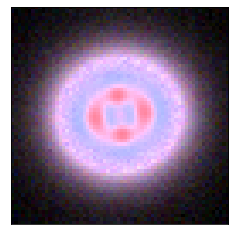

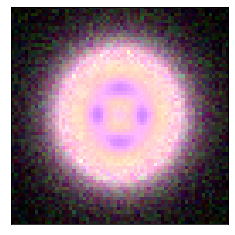

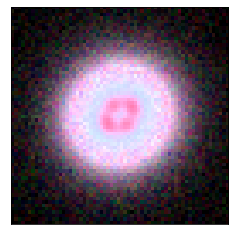

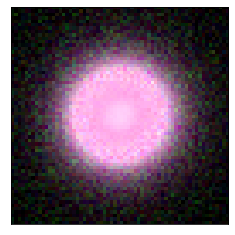

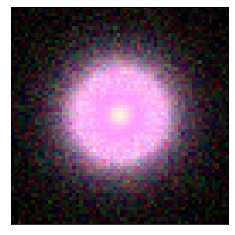

In [ ]:
for i in range(5):
    view_image_rgb(images[i])

Vamos também garantir que estamos trabalhando na GPU, que permite treinamento mais rápido

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

if torch.cuda.is_available() is True:
    print(torch.cuda.get_device_name(0))

Device: cuda
Tesla T4


Finalmente, fixamos as sementes para manter o código reprodutível

In [ ]:
# Fixe as seeds para manter o código reprodutível
torch.manual_seed(42)
np.random.seed(42)

# Preparação das imagens
vamos normalizar as imagens antes usá-las no treinamento do modelo

In [ ]:
def normalize_array(arr): 
    # normaliza um array inplace
    min = np.min(arr)
    max = np.max(arr)
    
    range = max - min

    arr -= min
    arr /= range

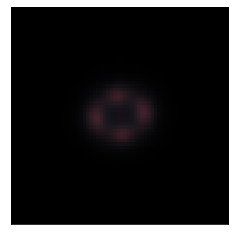

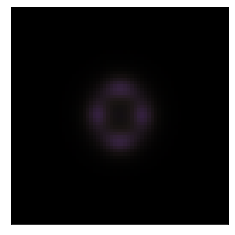

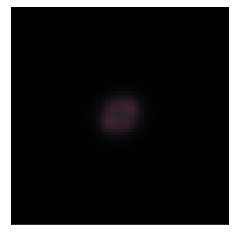

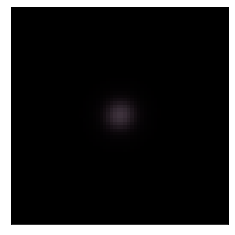

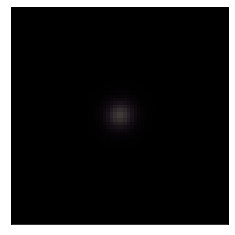

In [ ]:
for image in images:
    normalize_array(image)

for i in range(5):
    view_image_rgb(images[i])

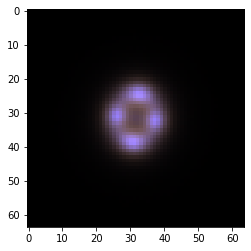

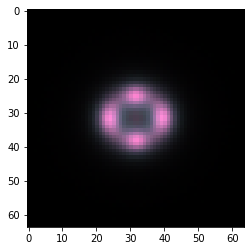

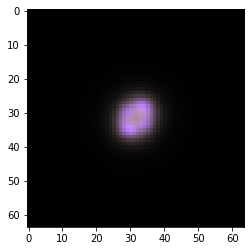

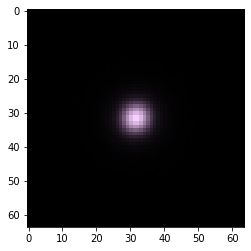

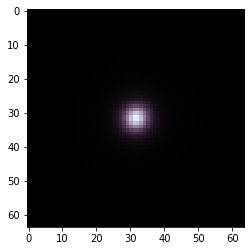

In [ ]:
for i in range(5):
    fig, ax = plt.subplots()
    ax.imshow(images[i].T) # Mostra as imagens transpostas porque o shape original é channels first e a função espera channels last

# Treinando o modelo
Nesta seção vamos treinar um modelo para fazer [Simulation-Based Inference](https://www.pnas.org/doi/10.1073/pnas.1912789117) (SBI) usando o método [Sequential Neural Posterior Estimation](https://arxiv.org/abs/1905.07488) (SNPE) e um MAF.

In [ ]:
# passamos os tensores pro torch na GPU
params = torch.tensor(params.to_numpy(), dtype=float32, device='cuda')
images = torch.tensor(images, dtype=float32, device='cuda')

print(params.shape)
print(images.shape)

torch.Size([10000, 6])
torch.Size([10000, 3, 64, 64])


In [ ]:
# Separamos parte do dataset para teste
train_images, test_images, train_params, test_params = train_test_split(images, params, test_size=0.1, random_state=42)

# Deixamos a parte do teste na cpu
test_images = test_images.cpu()
test_params = test_params.cpu()

print(train_params.shape)
print(train_images.shape)
print(test_params.shape)
print(test_images.shape)

torch.Size([9000, 6])
torch.Size([9000, 3, 64, 64])
torch.Size([1000, 6])
torch.Size([1000, 3, 64, 64])


Nesta célula definimos a Embedding Net, que é usada para sumarizar os features das imagens para o MAF

In [ ]:
#Começamos definindo a Embedding Net
embedding_net = CNNEmbedding(
        input_shape = (64, 64),
        in_channels  = 3,
        out_channels_per_layer = [8, 16, 32],
        num_conv_layers  = 3,
        num_linear_layers  = 1,
        num_linear_units  = 32,
        output_dim  = 16,
        kernel_size  = 3,
        pool_kernel_size = 2,
)

summary(embedding_net, input_size = (3, 64, 64), device='cpu') # Passamos para a cpu somente para o print

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             224
              ReLU-2            [-1, 8, 64, 64]               0
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
              ReLU-5           [-1, 16, 32, 32]               0
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
              ReLU-8           [-1, 32, 16, 16]               0
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Linear-10                   [-1, 32]          65,568
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 16]             528
             ReLU-13                   [-1, 16]               0
      FCEmbedding-14                   

Instanciamos o o objeto estimador de densidade

In [ ]:
neural_posterior = utils.posterior_nn(
                                        model="maf",
                                        embedding_net=embedding_net,
                                        hidden_features=128,
                                        num_transforms=4
                                        )

Definimos o processo de inferência, que vai usar o estimador de densidade e deve acontecer na gpu

In [ ]:
inference = SNPE( 
                 density_estimator=neural_posterior,
                 device='cuda'
                 )

/usr/local/lib/python3.8/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


E então carregamos os dados simulados para o modelo

In [ ]:
inference.append_simulations(train_params, train_images)

Por fim, treinamos o modelo. Usamos os hiperparâmetros padrão do pacote sbi: learning rate = 0.0005, batch size = 50. O otimizador disponível é o Adam. Por padrão, 10% dos dados carregados são usados para validação do treinamento.

In [ ]:
t_i = time()

density_estimator = inference.train(#training_batch_size=32,
                                    #learning_rate=0.0005
                                    #validation_fraction=0.1
)

t_f = time()

print('\nTempo de execução: {} segundos'.format(t_f-t_i))

 Neural network successfully converged after 202 epochs.
Tempo de execução: 489.1515693664551 segundos


dict_keys(['epochs_trained', 'best_validation_log_prob', 'validation_log_probs', 'training_log_probs', 'epoch_durations_sec'])


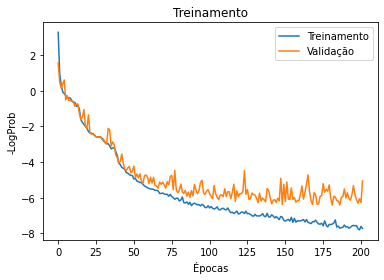

In [ ]:
# Agora avaliamos o processo de treinamento
training_history = inference._summary
print(training_history.keys())

fig, ax = plt.subplots()
ax.set_title('Treinamento')
ax.set_xlabel('Épocas')
ax.set_ylabel('-LogProb')
plt.plot([-item for item in training_history['training_log_probs']], label = 'Treinamento')
plt.plot([-item for item in training_history['validation_log_probs']], label = 'Validação')
plt.legend()

Por fim, criamos o objeto que será capaz de reconstruir uma distribuição posterior dada uma imagem. Este objeto será usado no dataset de teste para analisar a performance do modelo em dados novos.

In [ ]:
posterior = inference.build_posterior(density_estimator)

/usr/local/lib/python3.8/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


# Avaliação do conjunto de teste

## Para uma única Imagem
Vamos começar avaliando uma única imagem do conjunto de teste. Construimos a distribuição posterior dessa imagem com 10000 amostras.

In [ ]:
# Pegando uma única imagem do conjunto de teste
example_image = test_images[0:1] #[0:1] pq precisa ter a dimensão explicita ("batch size 1")
example_params = test_params[0:1]

# Construindo posterior de um elemento do dataset de teste
example_samples = posterior.set_default_x(example_image).sample((10000,)).cpu() 

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Plotamos um as distribuições do posterior para cada par de parâmetros

tensor([[ 2.2323e+02,  7.2787e-01, -3.0549e-02, -2.3513e-01,  2.0899e-01,
          6.8697e-01]])


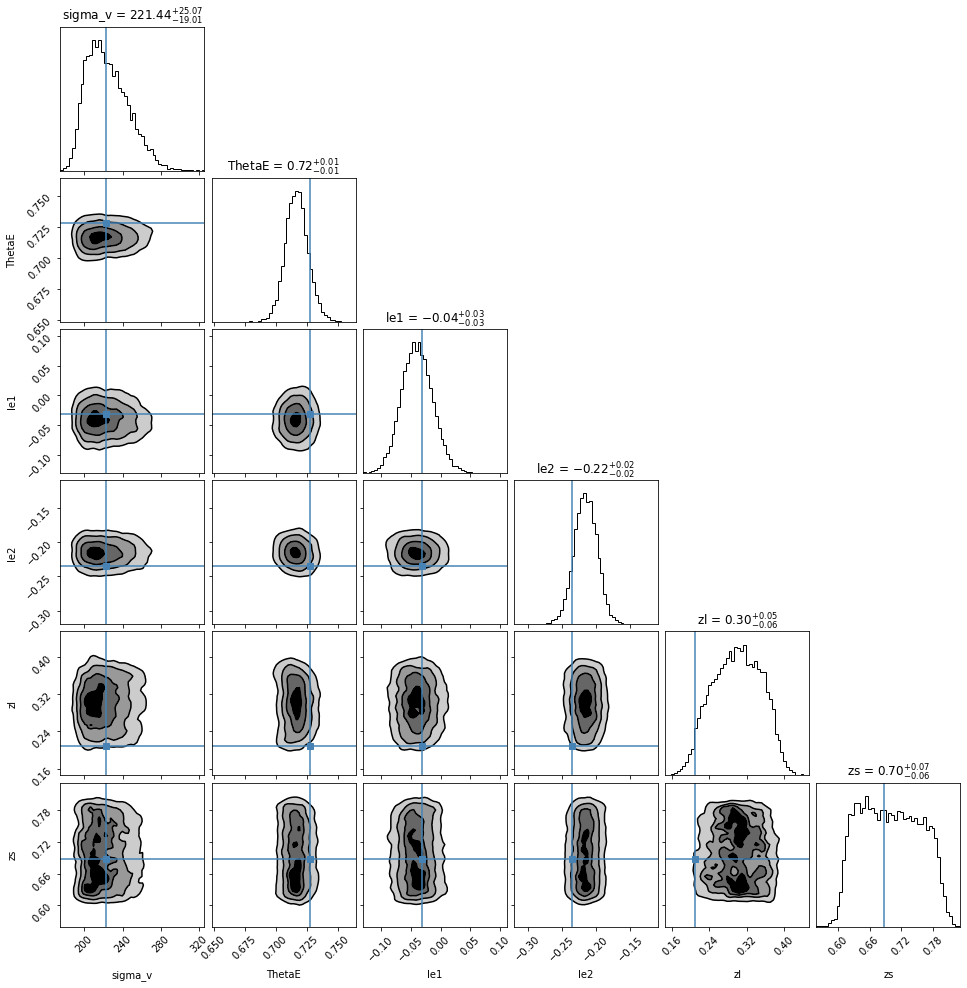

In [ ]:
figure = corner.corner(example_samples.numpy(),
                      labels=['sigma_v', 'ThetaE', 'le1', 'le2', 'zl', 'zs',], 
                      truths=example_params[0].numpy(), # precisa do [0] pq params tem dim [1, n], e queremos a lista de dimensão [n]
                      show_titles=True,
                      plot_datapoints=False, 
                      fill_contours=True, 
                      bins=50, 
                      smooth=1.0
                       )
print(example_params)

## Para o conjunto de teste como um todo

In [ ]:
print(test_params.shape)
print(test_images.shape)

torch.Size([1000, 6])
torch.Size([1000, 3, 64, 64])


Criamos uma função para analisar uma única imagem e aplicamos em loop sobre o dataset

In [ ]:
def single_image_analysis(image, real_params, print_estimate = False):
    #Prepara a imagem para tirar posterior
    #print(image.shape)
    img = np.expand_dims(image, axis=0)
    #print(img.shape)
    
    # Obtem samples da distribuição posterior de parametros dada a imagem
    post_samples = posterior.set_default_x(img).sample((5000,), show_progress_bars = False).cpu()
    
    # Encontra a porcentagem mínima do posterior necessária para encontrar o valor real
    sigmaV_perc_real_value = percentileofscore(post_samples[:, 0], real_params[0].numpy()) # a porcentagem do posterior necessária para encontrar o valor real
    thetaE_perc_real_value = percentileofscore(post_samples[:, 1], real_params[1].numpy()) # a porcentagem do posterior necessária para encontrar o valor real
    e1_perc_real_value = percentileofscore(post_samples[:, 2], real_params[2].numpy()) # a porcentagem do posterior necessária para encontrar o valor real
    e2_perc_real_value = percentileofscore(post_samples[:, 3], real_params[3].numpy()) # a porcentagem do posterior necessária para encontrar o valor real
    zl_perc_real_value = percentileofscore(post_samples[:, 4], real_params[4].numpy()) # a porcentagem do posterior necessária para encontrar o valor real
    zs_perc_real_value = percentileofscore(post_samples[:, 5], real_params[5].numpy()) # a porcentagem do posterior necessária para encontrar o valor real

    #print(post_samples.shape)

    # Separa em listas idividuais:
    sigmaV_data = post_samples[:,0].numpy()
    thetaE_data = post_samples[:,1].numpy()
    e1_data = post_samples[:,2].numpy()
    e2_data = post_samples[:,3].numpy()
    zl_data = post_samples[:,4].numpy()
    zs_data = post_samples[:,5].numpy()
    
    #print(thetaE_data)

    # Calcula estatísticas individuais:
    sigmaV_median = np.quantile(sigmaV_data, 0.5) # equivalente a np.median(thetaE_data)
    sigmaV_sigma_plus = np.quantile(sigmaV_data, 0.5+0.34) - sigmaV_median
    sigmaV_sigma_minus = abs(np.quantile(sigmaV_data, 0.5-0.34) - sigmaV_median)

    thetaE_median = np.quantile(thetaE_data, 0.5) # equivalente a np.median(thetaE_data)
    thetaE_sigma_plus = np.quantile(thetaE_data, 0.5+0.34) - thetaE_median
    thetaE_sigma_minus = abs(np.quantile(thetaE_data, 0.5-0.34) - thetaE_median)
    
    e1_median = np.quantile(e1_data, 0.5) # equivalente a np.median(e1_data)
    e1_sigma_plus = np.quantile(e1_data, 0.5+0.34) - e1_median
    e1_sigma_minus = abs(np.quantile(e1_data, 0.5-0.34) - e1_median)

    e2_median = np.quantile(e2_data, 0.5) # equivalente a np.median(e2_data)
    e2_sigma_plus = np.quantile(e2_data, 0.5+0.34) - e2_median
    e2_sigma_minus = abs(np.quantile(e2_data, 0.5-0.34) - e2_median)

    zl_median = np.quantile(zl_data, 0.5) # equivalente a np.median(zl_data)
    zl_sigma_plus = np.quantile(zl_data, 0.5+0.34) - zl_median
    zl_sigma_minus = abs(np.quantile(zl_data, 0.5-0.34) - zl_median)

    zs_median = np.quantile(zs_data, 0.5) # equivalente a np.median(zs_data)
    zs_sigma_plus = np.quantile(zs_data, 0.5+0.34) - zs_median
    zs_sigma_minus = abs(np.quantile(zs_data, 0.5-0.34) - zs_median)

    # Printa caso desejado
    if print_estimate:
        print('thetaE = {} + {} - {}'.format(thetaE_median, thetaE_sigma_plus, thetaE_sigma_minus))
        print('e1 = {} + {} - {}'.format(e1_median, e1_sigma_plus, e1_sigma_minus))
        print('e2 = {} + {} - {}'.format(e2_median, e2_sigma_plus, e2_sigma_minus))
    
    # retorna lista com medianas 3 dos params, lista com sigma+ 3 dos params e lista com sigma- 3 dos params
    return [sigmaV_median, thetaE_median, e1_median, e2_median, zl_median, zs_median], [sigmaV_sigma_plus, thetaE_sigma_plus, e1_sigma_plus, e2_sigma_plus, zl_sigma_plus, zs_sigma_plus], [sigmaV_sigma_minus, thetaE_sigma_minus, e1_sigma_minus, e2_sigma_minus, zl_sigma_minus, zs_sigma_minus], [sigmaV_perc_real_value, thetaE_perc_real_value, e1_perc_real_value, e2_perc_real_value, zl_perc_real_value, zs_perc_real_value]

single_image_analysis(test_images[0], test_params[0], print_estimate=False)

([221.56201934814453,
  0.7167335152626038,
  -0.03992641158401966,
  -0.21601780503988266,
  0.3000016361474991,
  0.6988924443721771],
 [24.6698617553711,
  0.009205281734466553,
  0.02614147555083038,
  0.017387414872646334,
  0.05530415594577792,
  0.0625519979000092],
 [18.89480926513673,
  0.009281764030456552,
  0.025014312788844112,
  0.016614786684513105,
  0.0574738073348999,
  0.06200094819068913],
 [52.9, 88.02, 64.0, 12.66, 3.22, 43.32])

In [ ]:
test_medians = []
test_sigma_p = []
test_sigma_m = []
test_perc_real_values = []

for index, image in enumerate(test_images):

    medians, sigma_p, sigma_m, perc_real_values = single_image_analysis(image, test_params[index])
    
    test_medians.append(medians)
    test_sigma_p.append(sigma_p)
    test_sigma_m.append(sigma_m)
    test_perc_real_values.append(perc_real_values)

test_medians = np.array(test_medians)
test_sigma_p = np.array(test_sigma_p)
test_sigma_m = np.array(test_sigma_m)
test_perc_real_values = np.array(test_perc_real_values)

Podemos então calcular a métrica $R^2$, que quantifica a correlação entre o valor medido e o valor real

In [ ]:
# R2 score
r2 = r2_score(y_true = test_params, y_pred = test_medians, multioutput='raw_values')

print('R2 sigmaV: {}'.format(r2[0]))
print('R2 thetaE: {}'.format(r2[1]))
print('R2 e1: {}'.format(r2[2]))
print('R2 e2: {}'.format(r2[3]))
print('R2 zl: {}'.format(r2[4]))
print('R2 zs: {}'.format(r2[5]))

R2 sigmaV: 0.9028287191066099
R2 thetaE: 0.9993766708200815
R2 e1: 0.9756099853813023
R2 e2: 0.9873183323049043
R2 zl: -0.007343119905579565
R2 zs: -0.0058447761060944625


Fazemos também os Plots 1x1, onde temos o valor real no eixo X e o valor predito no eixo y

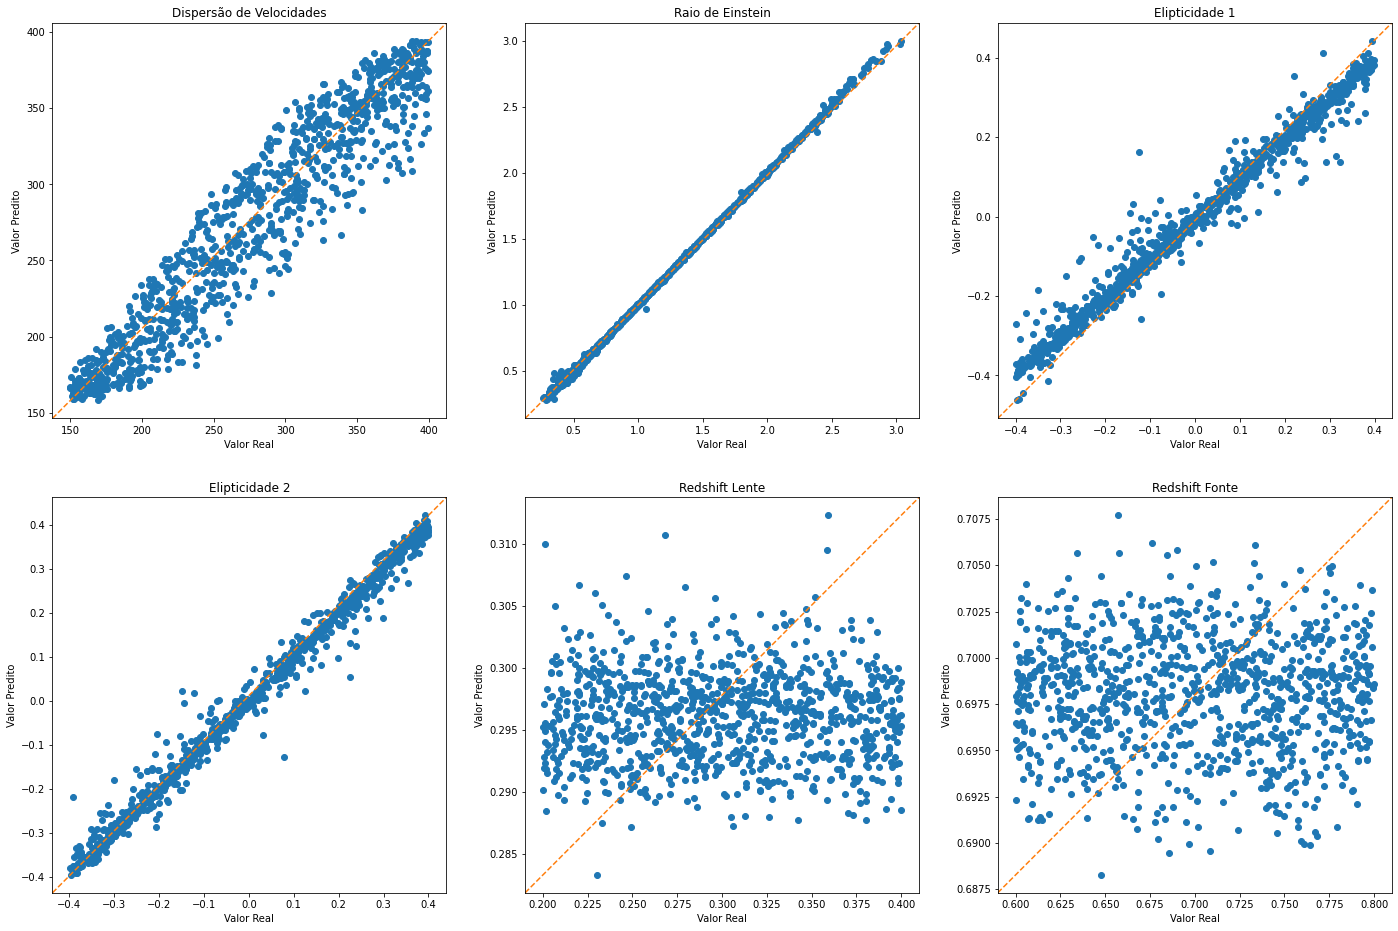

In [ ]:
# plot 1x1

fig, axs = plt.subplots(2, 3, figsize = (24, 16))

axs[0,0].set_title('Dispersão de Velocidades')
axs[0,0].set_xlabel('Valor Real')
axs[0,0].set_ylabel('Valor Predito')
axs[0,0].scatter(test_params[:, 0], test_medians[:, 0])
axs[0,0].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,0].transAxes) # plota linha tracejada que percorre todo o espaço mas não altera espaço do plot (argumento transform)

axs[0,1].set_title('Raio de Einstein')
axs[0,1].set_xlabel('Valor Real')
axs[0,1].set_ylabel('Valor Predito')
axs[0,1].scatter(test_params[:, 1], test_medians[:, 1])
axs[0,1].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,1].transAxes)

axs[0,2].set_title('Elipticidade 1')
axs[0,2].set_xlabel('Valor Real')
axs[0,2].set_ylabel('Valor Predito')
axs[0,2].scatter(test_params[:, 2], test_medians[:, 2])
axs[0,2].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,2].transAxes)

axs[1,0].set_title('Elipticidade 2')
axs[1,0].set_xlabel('Valor Real')
axs[1,0].set_ylabel('Valor Predito')
axs[1,0].scatter(test_params[:, 3], test_medians[:, 3])
axs[1,0].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,0].transAxes) # plota linha tracejada que percorre todo o espaço mas não altera espaço do plot (argumento transform)

axs[1,1].set_title('Redshift Lente')
axs[1,1].set_xlabel('Valor Real')
axs[1,1].set_ylabel('Valor Predito')
axs[1,1].scatter(test_params[:, 4], test_medians[:, 4])
axs[1,1].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,1].transAxes) # plota linha tracejada que percorre todo o espaço mas não altera espaço do plot (argumento transform)

axs[1,2].set_title('Redshift Fonte')
axs[1,2].set_xlabel('Valor Real')
axs[1,2].set_ylabel('Valor Predito')
axs[1,2].scatter(test_params[:, 5], test_medians[:, 5])
axs[1,2].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,2].transAxes)

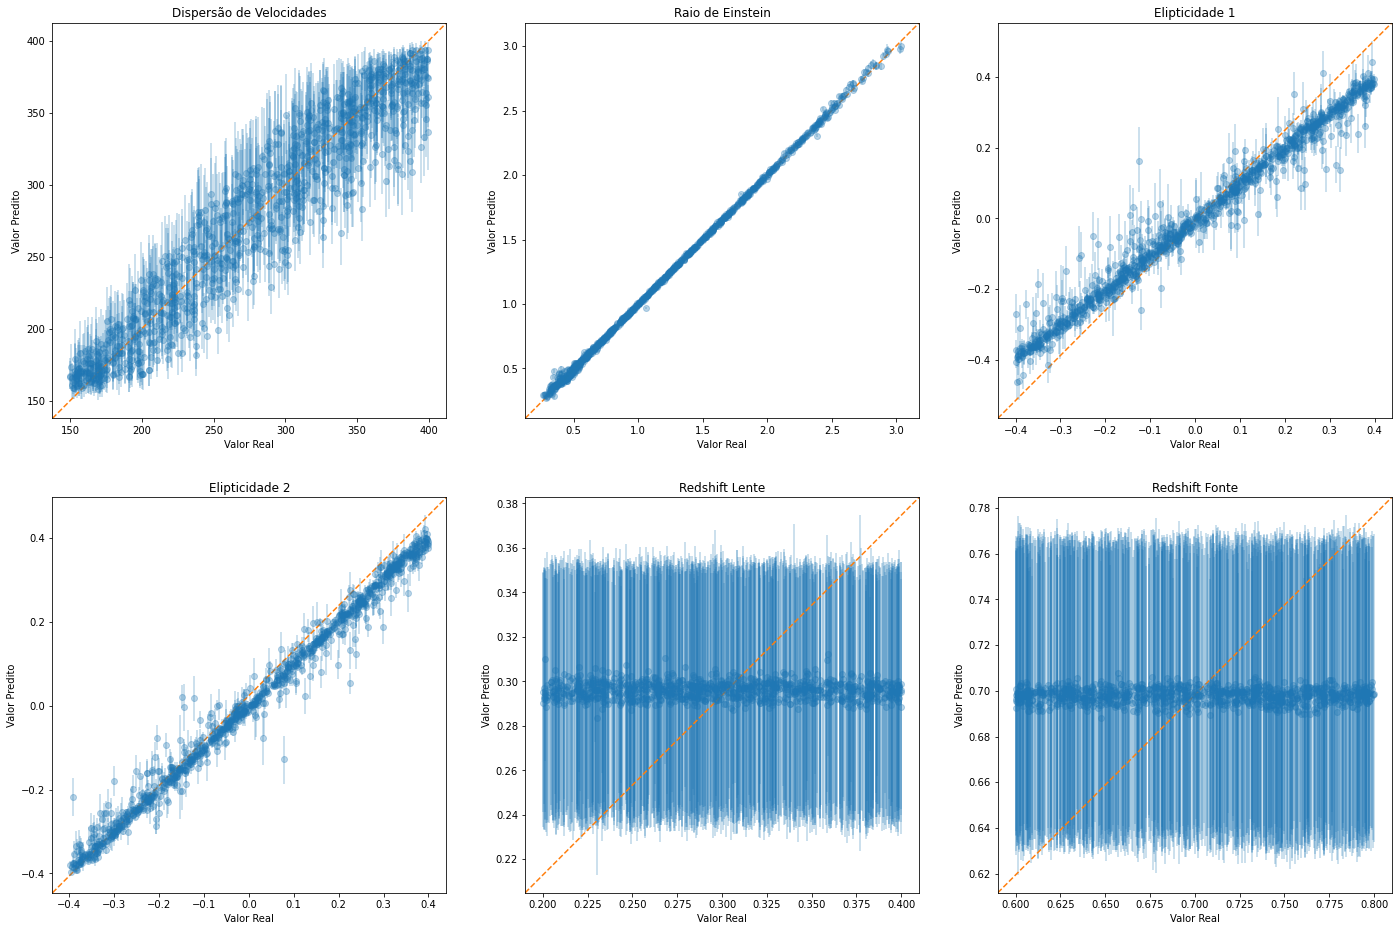

In [ ]:
# plot 1x1 com erros

fig, axs = plt.subplots(2, 3, figsize = (24, 16))

axs[0,0].set_title('Dispersão de Velocidades')
axs[0,0].set_xlabel('Valor Real')
axs[0,0].set_ylabel('Valor Predito')
axs[0,0].errorbar(test_params[:, 0], test_medians[:, 0], yerr=[test_sigma_m[:, 0], test_sigma_p[:, 0]], fmt="o", alpha=0.3) 
axs[0,0].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,0].transAxes) # plota linha tracejada que percorre todo o espaço mas não altera espaço do plot (argumento transform)

axs[0,1].set_title('Raio de Einstein')
axs[0,1].set_xlabel('Valor Real')
axs[0,1].set_ylabel('Valor Predito')
axs[0,1].errorbar(test_params[:, 1], test_medians[:, 1], yerr=[test_sigma_m[:, 1], test_sigma_p[:, 1]], fmt="o", alpha=0.3)
axs[0,1].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,1].transAxes)

axs[0,2].set_title('Elipticidade 1')
axs[0,2].set_xlabel('Valor Real')
axs[0,2].set_ylabel('Valor Predito')
axs[0,2].errorbar(test_params[:, 2], test_medians[:, 2], yerr=[test_sigma_m[:, 2], test_sigma_p[:, 2]], fmt="o", alpha=0.3)
axs[0,2].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,2].transAxes)

axs[1,0].set_title('Elipticidade 2')
axs[1,0].set_xlabel('Valor Real')
axs[1,0].set_ylabel('Valor Predito')
axs[1,0].errorbar(test_params[:, 3], test_medians[:, 3], yerr=[test_sigma_m[:, 3], test_sigma_p[:, 3]], fmt="o", alpha=0.3)
axs[1,0].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,0].transAxes) 

axs[1,1].set_title('Redshift Lente')
axs[1,1].set_xlabel('Valor Real')
axs[1,1].set_ylabel('Valor Predito')
axs[1,1].errorbar(test_params[:, 4], test_medians[:, 4], yerr=[test_sigma_m[:, 4], test_sigma_p[:, 4]], fmt="o", alpha=0.3)#axs[0].plot([0.4, 4.1], [0.4, 4.1], '--', color='C1')
axs[1,1].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,1].transAxes)

axs[1,2].set_title('Redshift Fonte')
axs[1,2].set_xlabel('Valor Real')
axs[1,2].set_ylabel('Valor Predito')
axs[1,2].errorbar(test_params[:, 5], test_medians[:, 5], yerr=[test_sigma_m[:, 5], test_sigma_p[:, 5]], fmt="o", alpha=0.3)
axs[1,2].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,2].transAxes)

Podemos também calcular o resíduo de cada Fit usando a equação
\begin{equation}
\text{Res} = \frac{ V_{\text{Real}} - V_{\text{Predito}} }{V_{\text{Real}}}
\end{equation}
Fazemos isso para cada sample elemento do dataset. Podemos então calcular o resíduo médio de cada parâmetro e plotar a distribuição do resíduo de cada parâmetro.

Resíduo médio em sigmaV: 0.06721795453694913
Resíduo médio em thetaE: 0.01386862355291483
Resíduo médio em e1: 0.2688003256129992
Resíduo médio em e2: 0.1786808512667635
Resíduo médio em zl: 0.1705482301805905
Resíduo médio em zs: 0.0741919790525876


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 15., 59., 44., 65., 56., 61., 53., 66., 70., 54.,
        78., 72., 94., 89., 87., 37.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <a list of 50 Patch objects>)

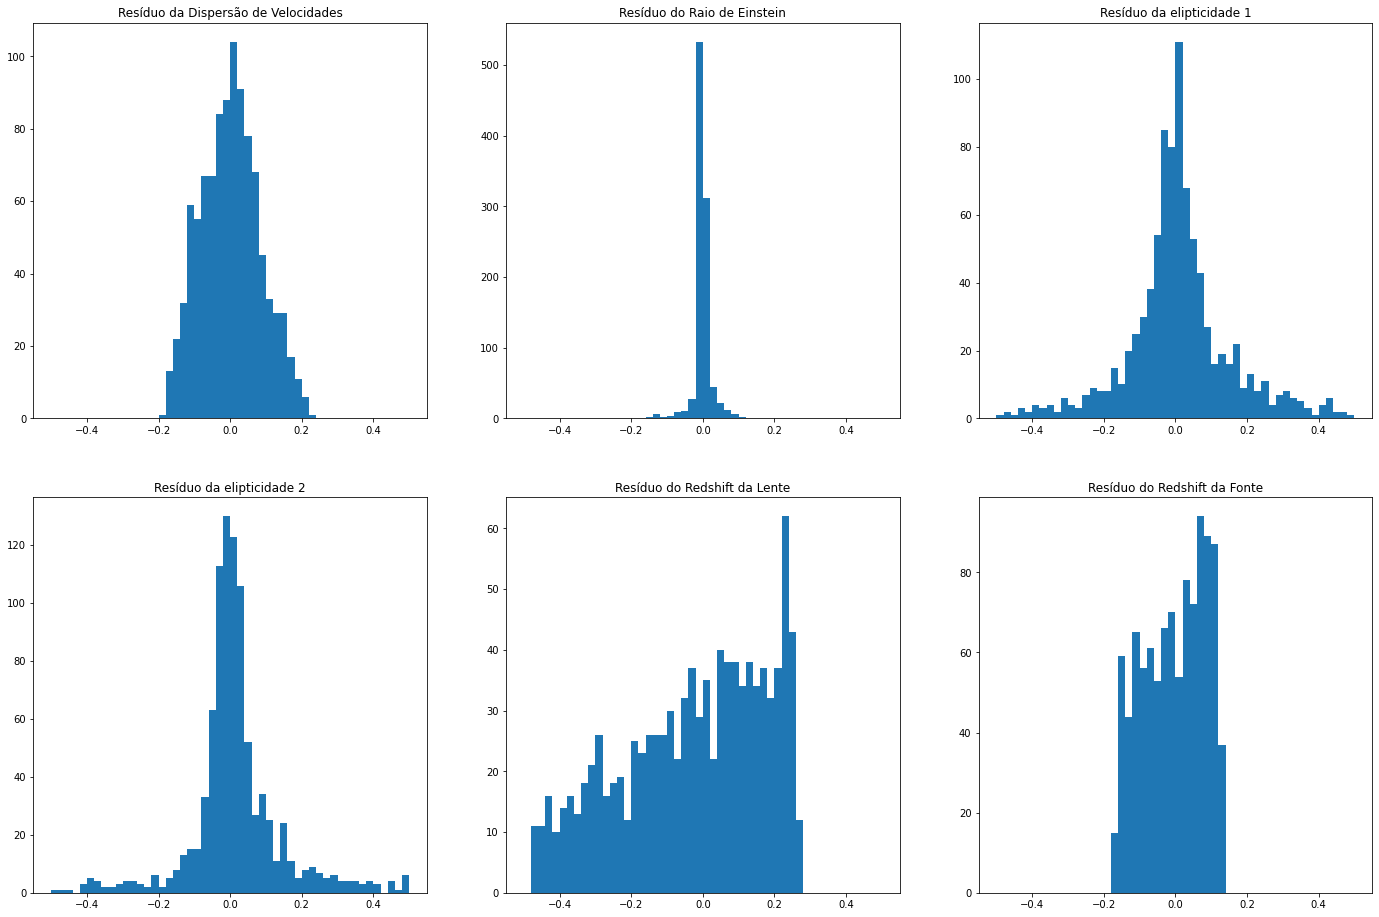

In [ ]:
residue = 1 - test_medians / test_params.numpy() # gera array com residuo de cada caso

print('Resíduo médio em sigmaV: {}'.format(np.mean(abs(residue[:,0]))))
print('Resíduo médio em thetaE: {}'.format(np.mean(abs(residue[:,1]))))
print('Resíduo médio em e1: {}'.format(np.mean(abs(residue[:,2]))))
print('Resíduo médio em e2: {}'.format(np.mean(abs(residue[:,3]))))
print('Resíduo médio em zl: {}'.format(np.mean(abs(residue[:,4]))))
print('Resíduo médio em zs: {}'.format(np.mean(abs(residue[:,5]))))

fig, axs = plt.subplots(2, 3, figsize = (24, 16))

axs[0,0].set_title('Resíduo da Dispersão de Velocidades')
axs[0,0].hist(residue[:,0], bins=50, range=[-0.5, 0.5])

axs[0,1].set_title('Resíduo do Raio de Einstein')
axs[0,1].hist(residue[:,1], bins=50, range=[-0.5, 0.5])

axs[0,2].set_title('Resíduo da elipticidade 1')
axs[0,2].hist(residue[:,2], bins=50, range=[-0.5, 0.5])

axs[1,0].set_title('Resíduo da elipticidade 2')
axs[1,0].hist(residue[:,3], bins=50, range=[-0.5, 0.5])

axs[1,1].set_title('Resíduo do Redshift da Lente')
axs[1,1].hist(residue[:,4], bins=50, range=[-0.5, 0.5])

axs[1,2].set_title('Resíduo do Redshift da Fonte')
axs[1,2].hist(residue[:,5], bins=50, range=[-0.5, 0.5])

In [ ]:
# Soma dos quadrados dos resíduos
print('SSR em sigmaV: {}'.format(np.sum(residue[:,0]**2)))
print('SSR em thetaE: {}'.format(np.sum(residue[:,1]**2)))
print('SSR em e1: {}'.format(np.sum(residue[:,2]**2)))
print('SSR em e2: {}'.format(np.sum(residue[:,3]**2)))
print('SSR em zl: {}'.format(np.sum(residue[:,4]**2)))
print('SSR em zs: {}'.format(np.sum(residue[:,5]**2)))

SSR em sigmaV: 6.889769118181746
SSR em thetaE: 0.9540027663852867
SSR em e1: 1641.5666331428001
SSR em e2: 356.33640526694904
SSR em zl: 42.00892409933239
SSR em zs: 7.3283363933884225


Por fim, vamos plotar os Posterior Coverage Plots. Uma distribuição é considerada bem calibrada se x% do posterior cobre o valor real x% das vezes. Exemplo: Só esperamos que os primeiros 10% de uma distribuição cubram o valor real 10% das vezes. Isto é equivalente a dizer que que o valor real está abaixo do décimo percentil.

In [ ]:
# volumes de posterior onde vamos avaliar a cobertura
posterior_volumes = np.linspace(0, 100, 20)

# Para sigmaV
posterior_coverage_sigmaV = [] 
for covered_percentage in posterior_volumes: 
    # Para cada volume da lista, conta quantos elementos em perc_real_values estão cobertos 
    post_coverage = np.count_nonzero(test_perc_real_values[:, 0] < covered_percentage) # Calculado para sigmaV
    posterior_coverage_sigmaV.append(post_coverage)

norm_pc_sigmaV = [item/test_perc_real_values.shape[0] for item in posterior_coverage_sigmaV] # normaliza as contagens


# Para thetaE
posterior_coverage_thetaE = [] 
for covered_percentage in posterior_volumes: 
    # Para cada volume da lista, conta quantos elementos em perc_real_values estão cobertos 
    post_coverage = np.count_nonzero(test_perc_real_values[:, 1] < covered_percentage) # Calculado para thetaE
    posterior_coverage_thetaE.append(post_coverage)

norm_pc_thetaE = [item/test_perc_real_values.shape[0] for item in posterior_coverage_thetaE]


# Para e1
posterior_coverage_e1 = [] 
for covered_percentage in posterior_volumes: 
    # Para cada volume da lista, conta quantos elementos em perc_real_values estão cobertos 
    post_coverage = np.count_nonzero(test_perc_real_values[:, 2] < covered_percentage) # Calculado para e1
    posterior_coverage_e1.append(post_coverage)

norm_pc_e1 = [item/test_perc_real_values.shape[0] for item in posterior_coverage_e1]


# Para e2
posterior_coverage_e2 = [] 
for covered_percentage in posterior_volumes: 
    # Para cada volume da lista, conta quantos elementos em perc_real_values estão cobertos 
    post_coverage = np.count_nonzero(test_perc_real_values[:, 3] < covered_percentage) # Calculado para e2
    posterior_coverage_e2.append(post_coverage)

norm_pc_e2 = [item/test_perc_real_values.shape[0] for item in posterior_coverage_e2]

#
posterior_coverage_zl = [] 
for covered_percentage in posterior_volumes: 
    # Para cada volume da lista, conta quantos elementos em perc_real_values estão cobertos 
    post_coverage = np.count_nonzero(test_perc_real_values[:, 4] < covered_percentage) 
    posterior_coverage_zl.append(post_coverage)

norm_pc_zl = [item/test_perc_real_values.shape[0] for item in posterior_coverage_zl] 


posterior_coverage_zs = [] 
for covered_percentage in posterior_volumes: 
    # Para cada volume da lista, conta quantos elementos em perc_real_values estão cobertos 
    post_coverage = np.count_nonzero(test_perc_real_values[:, 5] < covered_percentage) 
    posterior_coverage_zs.append(post_coverage)

norm_pc_zs = [item/test_perc_real_values.shape[0] for item in posterior_coverage_sigmaV]

# Por fim, normalizamos as probabilidades
norm_pv = [item/100 for item in posterior_volumes]

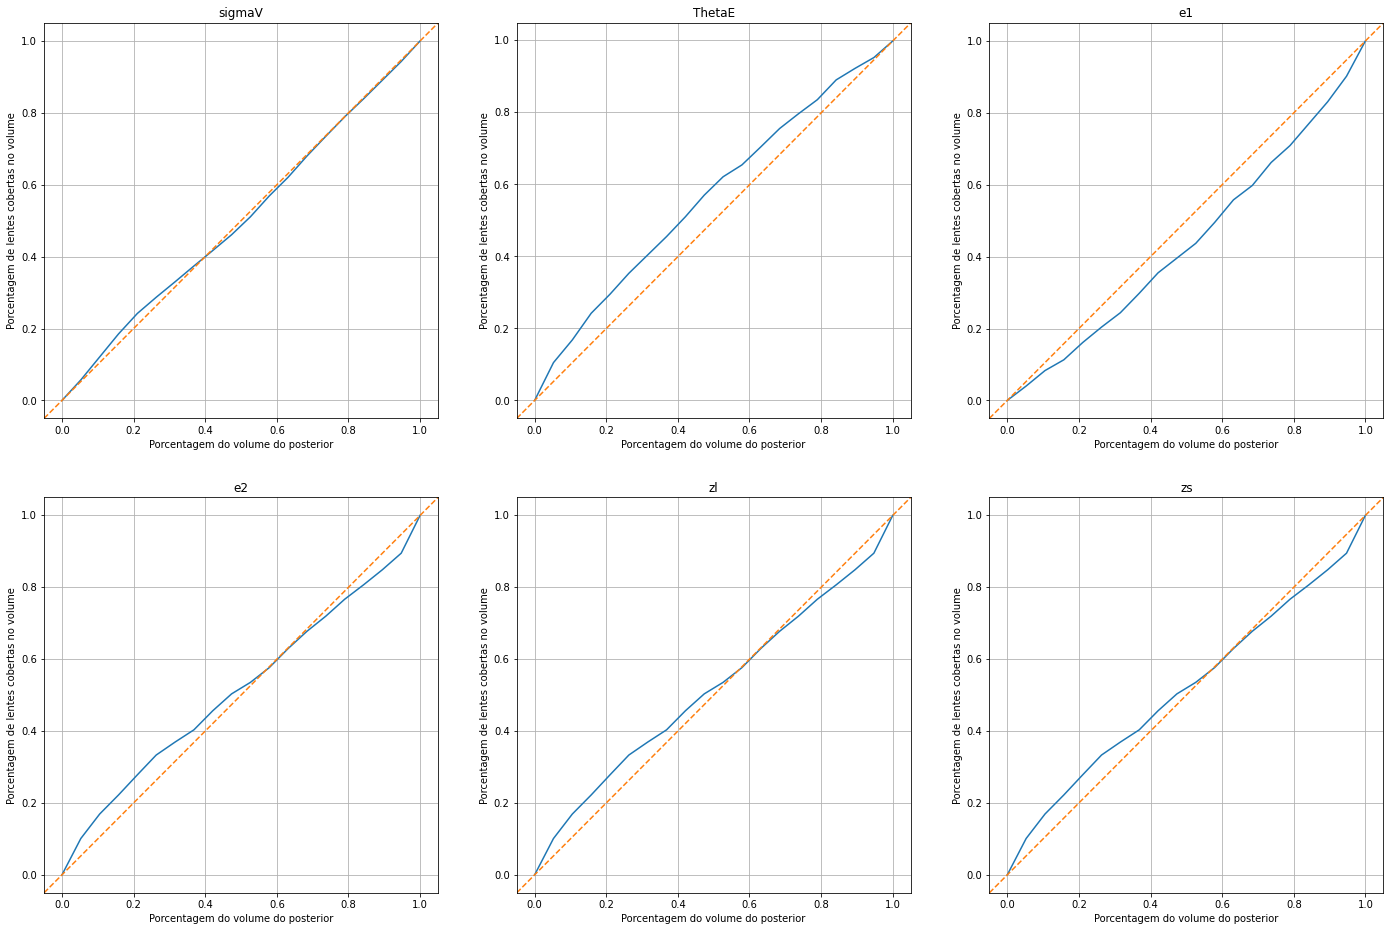

In [ ]:
# plot
fig, axs = plt.subplots(2, 3, figsize = (24, 16))

axs[0,0].set_title('sigmaV')
axs[0,0].set_ylabel('Porcentagem de lentes cobertas no volume')
axs[0,0].set_xlabel('Porcentagem do volume do posterior')
axs[0,0].plot(norm_pv, norm_pc_sigmaV)
axs[0,0].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,0].transAxes)
axs[0,0].grid()

axs[0,1].set_title('ThetaE')
axs[0,1].set_ylabel('Porcentagem de lentes cobertas no volume')
axs[0,1].set_xlabel('Porcentagem do volume do posterior')
axs[0,1].plot(norm_pv, norm_pc_thetaE)
axs[0,1].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,1].transAxes)
axs[0,1].grid()

axs[0,2].set_title('e1')
axs[0,2].set_ylabel('Porcentagem de lentes cobertas no volume')
axs[0,2].set_xlabel('Porcentagem do volume do posterior')
axs[0,2].plot(norm_pv, norm_pc_e1)
axs[0,2].plot([0, 1], [0, 1], '--', color='C1', transform=axs[0,2].transAxes)
axs[0,2].grid()

axs[1,0].set_title('e2')
axs[1,0].set_ylabel('Porcentagem de lentes cobertas no volume')
axs[1,0].set_xlabel('Porcentagem do volume do posterior')
axs[1,0].plot(norm_pv, norm_pc_e2)
axs[1,0].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,0].transAxes)
axs[1,0].grid()

axs[1,1].set_title('zl')
axs[1,1].set_ylabel('Porcentagem de lentes cobertas no volume')
axs[1,1].set_xlabel('Porcentagem do volume do posterior')
axs[1,1].plot(norm_pv, norm_pc_e2)
axs[1,1].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,1].transAxes)
axs[1,1].grid()

axs[1,2].set_title('zs')
axs[1,2].set_ylabel('Porcentagem de lentes cobertas no volume')
axs[1,2].set_xlabel('Porcentagem do volume do posterior')
axs[1,2].plot(norm_pv, norm_pc_e2)
axs[1,2].plot([0, 1], [0, 1], '--', color='C1', transform=axs[1,2].transAxes)
axs[1,2].grid()